# Section 2:  Introduction to Supervised Machine Learning with Scikit-Learn 
Welcome to the second module in the AMS Machine Learning in Python for Environmental Science Problems 2019.
This module will introduce you to the basics of machine learning in Python.
We'll be using scikit-learn, one of the most extensive and widely used machine learning libraries in Python.

This Notebook will walk you through some examples training machine learning models.
Some additional details can be found in separate course notes that accompany this module.
Students are invited to follow along with these notes and retain them as an additional reference.

We'll start with some preliminaries: importing the modules we'll be using and defining some functions we'll be using later. We'll revisit the functions and elaborate more on their construction later in the module as we use them.

In [570]:
import matplotlib
%matplotlib inline

import numpy as np
import numpy
import math
import pandas as pd
import glob
import time
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.decomposition
import sklearn.ensemble
import sklearn.metrics
import sklearn.tree
import sklearn.preprocessing
from sklearn.externals import joblib

In [571]:
PREDICTORS = ['Forecast_Hour', 'Valid_Hour_UTC', 'Duration', 'Centroid_Lon', 'Centroid_Lat', 'Storm_Motion_U', 'Storm_Motion_V',
         'REFL_COM_mean', 'REFL_COM_max', 'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10', 'REFL_COM_percentile_25',
         'REFL_COM_percentile_50', 'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean', 'U10_max', 'U10_min',
         'U10_std', 'U10_percentile_10', 'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75', 'U10_percentile_90',
         'V10_mean', 'V10_max', 'V10_min', 'V10_std', 'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50', 'V10_percentile_75',
         'V10_percentile_90','T2_mean', 'T2_max', 'T2_min', 'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50', 
         'T2_percentile_75', 'T2_percentile_90']

#PREDICTAND = 'RVORT1_MAX-future_max'
PREDICTAND = 'HAIL_MAXK1-future_max'

SHORTEN_TRAIN = True
SHORTEN_MAG = 250
SAVE_FIGS = False

plot_dir = './plots'
out_dir = './models'

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'

DEFAULT_NUM_STEPS_FOR_LOSS_DECREASE = 5

MIN_DECREASE_KEY = 'min_loss_decrease'
MIN_PERCENT_DECREASE_KEY = 'min_percentage_loss_decrease'
NUM_STEPS_FOR_DECREASE_KEY = 'num_steps_for_loss_decrease'
SELECTED_PREDICTORS_KEY = 'selected_predictor_name_by_step'
LOWEST_COSTS_KEY = 'lowest_cost_by_step'

CRIT_THRESH = 0.01
CRIT_THRESH2 = 0.001
N_FOLDS = 3
DEFAULT_VALUE = 9999999999

In [572]:
def load_files():
    """
    Loads the data to be used for subsequent analysis.
    """
    path = "../data/track_data_ncar_ams_3km_csv_small/"
    #path = "~/ams-ml-python-course/data/track_data_ncar_ams_3km_csv_small/"
    files = sorted(glob.glob(path+"/*.csv"))
    print("Files:")
    print(files)
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return df

In [573]:
def train_linear(train_df, target, alpha=0, l1_ratio=0.5):
    """
    This function trains a linear model given an alpha and l1_ratio.
    Performs unregularized linear regression by default.

    Parameters
    ----------
    train_df : numpy array (num_recs x num_features)
    Training matrix.

    target : numpy array (num_recs)
    Training target vector.

    alpha : float
    Regularization parameter. Nonnegative; larger value indicates more regularization.

    l1_ratio : float
    Must be between 0 and 1, inclusive; determines fraction of l1 vs l2 regularization.
    1 is all l1; 0 is all l2. Only used materially for ElasticNet.
    """
    assert 0 <= l1_ratio <= 1
    if alpha == 0:
        lm = sklearn.linear_model.LinearRegression()
    elif l1_ratio == 0:
        lm = sklearn.linear_model.Ridge(alpha=alpha)
    elif l1_ratio == 1:
        lm = sklearn.linear_model.Lasso(alpha=alpha)
    else:
        lm = sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    lm.fit(train_df, target)
    return lm

In [574]:
def partition_data(df, tar=None, n_folds=None, fold=None, test_frac=0.25):
    """
    Partitions data into training and test sets and, if not already performed, into feature and target values.
    NOTE: sklearn provides built-in functionality for this, but in general I recommend doing it yourself.
    Data partitioning is highly important, and when dealing with correlated training examples (as is
    typical in geoscientific problems), decisions can be quite consequential.
    Naively letting the library perform splitting for you can inadvertently result in adverse consequences.

    Parameters
    ----------
    df : numpy array (num_records x num_features) or pandas DataFrame
    If tar is supplied, this is the feature matrix.
    Otherwise, this is a DataFrame containing both feature and target values.
    The DataFrame must have all columns in both PREDICTORS and PREDITAND.

    tar : numpy array (num_records)
    The 1-D numpy array of target values.

    n_folds : int
    Number of folds if partitioning into train and validation for cross-validation.
    
    fold : int
    Current fold number (starting with 0) if partitioning into train and validation for cross-validation.

    test_frac : float
    The fraction of data to be preserved for testing/validation.
    Only used if fold and n_folds are not supplied.

    Returns
    -------
    train_preds : numpy array (num_train_recs x num_features)
    Training matrix.

    test_preds : numpy array (num_test_recs x num_features)
    Testing (validation) matrix.

    train_tar : numpy array (num_train_recs)
    Training target vector.

    test_tar : numpy array (num_test_recs)
    Testing (validation) target vector.
    """
    if tar is None:
        preds = df[PREDICTORS].values
        tar = df[PREDICTAND].values
    else:
        preds = df
    if n_folds is not None:
        test_frac = 1./float(n_folds)
    if fold is not None:
        start_frac = fold*test_frac
    else:
        start_frac = 1. - test_frac
    num_recs = preds.shape[0]
    start_ind = int(math.floor(num_recs*start_frac))
    end_ind = int(math.floor(num_recs*(start_frac+test_frac)))
    train_preds = np.append(preds[:start_ind,:], preds[end_ind:,:], axis=0)
    test_preds = preds[start_ind:end_ind,:]
    train_tar = np.append(tar[:start_ind], tar[end_ind:], axis=0)
    test_tar = tar[start_ind:end_ind]
    return train_preds, test_preds, train_tar, test_tar 

In [575]:
def calc_ss(err, err_base):
    """
    Simple function to calculate skill score from a loss and reference loss.
    """
    return 1. - (err / err_base)

In [576]:
def run_sfs_on_sklearn_model(
        training_predictor_matrix, training_target_values,
        validation_predictor_matrix, validation_target_values, predictor_names,
        model_object, cost_function, min_loss_decrease=None,
        min_percentage_loss_decrease=None,
        num_steps_for_loss_decrease=DEFAULT_NUM_STEPS_FOR_LOSS_DECREASE):
    """
    @author: Ryan Lagerquist
    Runs sequential forward selection (SFS) on scikit-learn model.
    T = number of training examples
    V = number of validation examples
    P = number of predictors
    :param training_predictor_matrix: T-by-P numpy array of predictor values.
    :param training_target_values: length-T numpy array of target values
        (integer class labels, since this method supports only classification).
    :param validation_predictor_matrix: V-by-P numpy array of predictor values.
    :param validation_target_values: length-V numpy array of target values.
    :param predictor_names: length-P list with names of predictor variables.
    :param model_object: Instance of scikit-learn model.  Must implement the
        methods `fit` and `predict_proba`.
    :param cost_function: Cost function (used to assess model on validation
        data).  Should have the following inputs and outputs.
    Input: target_values: Same as input `validation_target_values` for this
        method.
    Input: class_probability_matrix: V-by-K matrix of class probabilities, where
        K = number of classes.  class_probability_matrix[i, k] is the predicted
        probability that the [i]th example belongs to the [k]th class.
    Output: cost: Scalar value.
    :param min_loss_decrease: Used to determine stopping criterion.  If the loss
        has decreased by less than `min_loss_decrease` over the last
        `num_steps_for_loss_decrease` steps of sequential selection, the
        algorithm will stop.
    :param min_percentage_loss_decrease:
        [used only if `min_loss_decrease is None`]
        Used to determine stopping criterion.  If the loss has decreased by less
        than `min_percentage_loss_decrease` over the last
        `num_steps_for_loss_decrease` steps of sequential selection, the
        algorithm will stop.
    :param num_steps_for_loss_decrease: See above.
    :return: result_dict: See documentation for `run_sfs`.
    """
    num_training_examples = training_predictor_matrix.shape[0]
    num_predictors = training_predictor_matrix.shape[1]
    num_validation_examples = validation_predictor_matrix.shape[0]

    # Create climatological model.
    num_classes = 1 + max(
        [numpy.max(training_target_values), numpy.max(validation_target_values)]
    )

    climo_validation_prob_matrix = numpy.full(
        (num_validation_examples, num_classes), numpy.nan)
    for k in range(num_classes):
        climo_validation_prob_matrix[..., k] = numpy.mean(
            training_target_values == k)

    climo_cost = cost_function(validation_target_values,
                               climo_validation_prob_matrix)

    print('Cost of climatological model: {0:.4e}\n'.format(climo_cost)
)
    # Do dirty work.
    remaining_predictor_names = predictor_names + []
    selected_predictor_name_by_step = []
    lowest_cost_by_step = []

    step_num = 0

    while len(remaining_predictor_names) > 0:
        print('\n')
        step_num += 1

        lowest_cost = numpy.inf
        best_predictor_name = None

        for this_predictor_name in remaining_predictor_names:
            #print('Trying predictor {} at step {} of SFS...').format(this_predictor_name, step_num)

            these_indices = [
                predictor_names.index(s)
                for s in selected_predictor_name_by_step
            ]
            these_indices.append(predictor_names.index(this_predictor_name))
            these_indices = numpy.array(these_indices, dtype=int)

            this_training_matrix = training_predictor_matrix[..., these_indices]
            this_validation_matrix = validation_predictor_matrix[
                ..., these_indices]

            new_model_object = sklearn.base.clone(model_object)
            new_model_object.fit(this_training_matrix, training_target_values)

            this_validation_prob_matrix = new_model_object.predict_proba(
                this_validation_matrix)
            this_cost = cost_function(validation_target_values,
                                      this_validation_prob_matrix)

            print('Validation loss after adding "{}" = {}\n'.format(
                this_predictor_name, this_cost))

            if this_cost > lowest_cost:
                continue

            lowest_cost = this_cost + 0.
            best_predictor_name = this_predictor_name + ''

        stopping_criterion = _eval_sfs_stopping_criterion(
            min_loss_decrease=min_loss_decrease,
            min_percentage_loss_decrease=min_percentage_loss_decrease,
            num_steps_for_loss_decrease=num_steps_for_loss_decrease,
            lowest_cost_by_step=lowest_cost_by_step + [lowest_cost])

        if stopping_criterion:
            break

        selected_predictor_name_by_step.append(best_predictor_name)
        lowest_cost_by_step.append(lowest_cost)
        remaining_predictor_names.remove(best_predictor_name)

        print('Best predictor = "{}" ... new cost = {}'.format(
            best_predictor_name, lowest_cost))
        print(SEPARATOR_STRING
)
    return {
        MIN_DECREASE_KEY: min_loss_decrease,
        MIN_PERCENT_DECREASE_KEY: min_percentage_loss_decrease,
        NUM_STEPS_FOR_DECREASE_KEY: num_steps_for_loss_decrease,
        SELECTED_PREDICTORS_KEY: selected_predictor_name_by_step,
        LOWEST_COSTS_KEY: lowest_cost_by_step
    }

In [577]:
def _eval_sfs_stopping_criterion(
        min_loss_decrease, min_percentage_loss_decrease,
        num_steps_for_loss_decrease, lowest_cost_by_step):
    """
    @author: Ryan Lagerquist
    Evaluates stopping criterion for sequential forward selection (SFS).
    :param min_loss_decrease: If the loss has decreased by less than
        `min_loss_decrease` over the last `num_steps_for_loss_decrease` steps,
        the algorithm will stop.
    :param min_percentage_loss_decrease:
        [used only if `min_loss_decrease is None`]
        If the loss has decreased by less than `min_percentage_loss_decrease`
        over the last `num_steps_for_loss_decrease` steps, the algorithm will
        stop.
    :param num_steps_for_loss_decrease: See above.
    :param lowest_cost_by_step: 1-D numpy array, where the [i]th value is the
        cost after the [i]th step.  The last step is the current one, so the
        current cost is lowest_cost_by_step[-1].
    :return: stopping_criterion: Boolean flag.
    :raises: ValueError: if both `min_loss_decrease` and
        `min_percentage_loss_decrease` are None.
    """

    if min_loss_decrease is None and min_percentage_loss_decrease is None:
        raise ValueError('Either min_loss_decrease or '
                         'min_percentage_loss_decrease must be specified.')

    if min_loss_decrease is not None:
        min_percentage_loss_decrease = None

    if len(lowest_cost_by_step) <= num_steps_for_loss_decrease:
        return False

    previous_loss = lowest_cost_by_step[-(num_steps_for_loss_decrease + 1)]
    if min_loss_decrease is None:
        min_loss_decrease = previous_loss * min_percentage_loss_decrease / 100

    max_new_loss = previous_loss - min_loss_decrease

    #print(
    #    'Previous loss ({0:d} steps ago) = {} ... minimum loss decrease = '
    #    '{2:.4e} ... thus, max new loss = {} ... actual new loss = {4:.4e}'
    #).format(num_steps_for_loss_decrease, previous_loss, min_loss_decrease,
    #         max_new_loss, lowest_cost_by_step[-1])

    return lowest_cost_by_step[-1] > max_new_loss

In [578]:
def eval_regression_model(model, train_df, test_df, train_tar, test_tar):
    #Make some in- and out-of-sample predictions with the model; compare against baseline
    train_predictions = model.predict(train_df)
    test_predictions = model.predict(test_df)
    baseline_predictions_train = [np.mean(train_tar)]*len(train_predictions)
    baseline_predictions_test = [np.mean(np.append(train_tar,test_tar,axis=0))]*len(test_predictions)

    # Calculate Training Error/Skill
    mae_train = sklearn.metrics.mean_absolute_error(train_tar, train_predictions)
    rmse_train = np.sqrt(sklearn.metrics.mean_squared_error(train_tar, train_predictions))
    mae_train_base = sklearn.metrics.mean_absolute_error(train_tar, baseline_predictions_train)
    rmse_train_base = np.sqrt(sklearn.metrics.mean_squared_error(train_tar, baseline_predictions_train))
    mae_ss_train, rmse_ss_train = calc_ss(mae_train, mae_train_base), calc_ss(rmse_train, rmse_train_base)

    # ...And now for Test Error/Skill
    mae_test = sklearn.metrics.mean_absolute_error(test_tar, test_predictions)
    rmse_test = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, test_predictions))
    mae_test_base = sklearn.metrics.mean_absolute_error(test_tar, baseline_predictions_test)
    rmse_test_base = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, baseline_predictions_test))
    mae_ss_test, rmse_ss_test = calc_ss(mae_test, mae_test_base), calc_ss(rmse_test, rmse_test_base)

    print('In-Sample error stats (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_train, rmse_train))
    print('In-Sample baseline stats (MAE; RMSE): {}; {}'.format(mae_train_base, rmse_train_base))
    print('In-Sample skill scores (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_ss_train, rmse_ss_train))
    print('Out-of-Sample error stats (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_test, rmse_test))
    print('Out-of-Sample baseline stats (MAE; RMSE): {}; {}'.format(mae_test_base, rmse_test_base))
    print('Out-of-Sample skill scores (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_ss_test, rmse_ss_test))

In [579]:
def print_tree_info(estimator, max_node=1000):
    """
    Print some basic structural information about a supplied decision tree.
    @author: sklearn documentation
    Taken from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
    
    Parameters
    ----------
    estimator : sklearn DecisionTree
    The model to be analzyed.

    max_node : int
    Node number for when, if ever, to truncate printing of tree structure.
    Optional; defaults to 1000.
    """
    #
    # The decision estimator has an attribute called tree_  which stores the entire
    # tree structure and allows access to low level attributes. The binary tree
    # tree_ is represented as a number of parallel arrays. The i-th element of each
    # array holds information about the node `i`. Node 0 is the tree's root. NOTE:
    # Some of the arrays only apply to either leaves or split nodes, resp. In this
    # case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node
    #

    # Using those arrays, we can parse the tree structure:
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if i > max_node:
            print("Exceeded max node; truncating printing")
            return
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if %s <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     PREDICTORS[feature[i]],
                     threshold[i],
                     children_right[i],
                     ))
    print()


In [580]:
def print_tree_info_ext(estimator, X_test):
    """
    Prints additional information about a decision tree given the tree and a 
    set of validation examples.

    @author: sklearn documentation (see above for link).
    Parameters
    ----------
    estimator : sklearn DecisionTree
    The model to be analyzed
   
    X_test : numpy array (num_records x num_features)
    Set of test or validation examples to examine.
    """
    # First let's retrieve the decision path of each sample. The decision_path
    # method allows to retrieve the node indicator functions. A non zero element of
    # indicator matrix at the position (i, j) indicates that the sample i goes
    # through the node j.
    node_indicator = estimator.decision_path(X_test)

    # Similarly, we can also have the leaves ids reached by each sample.
    leave_id = estimator.apply(X_test)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.
    sample_id = 0
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]
    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:
        if leave_id[sample_id] == node_id:
            continue
        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
              % (node_id,
                 sample_id,
                 feature[node_id],
                 X_test[sample_id, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
    # For a group of samples, we have the following common node.
    sample_ids = [0, 1]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                    len(sample_ids))
    common_node_id = np.arange(n_nodes)[common_nodes]    
    print("\nThe following samples %s share the node %s in the tree"
          % (sample_ids, common_node_id))
    print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

In [581]:
def fancy_ind(inds, shape):
    """
    This simple function gives the index of the flattened array given the 
    indices in an unflattened array.
    
    Parameters
    ----------
    inds : list- or array-like
    List of indices in the unflattened array. 
    For sensical results, must all be less than value at corresponding index in 'shape'.
   
    shape : list- or array-like
    Dimension sizes in the unflattened array.
    """
    ind = 0
    for i in range(len(inds)):
        mult = 1
        for j in range(i+1, len(inds)):
            mult *= shape[j]
        ind += inds[i]*mult
    return ind

In [582]:
def rank_probability_score(vals_true, vals_pred):
    vals_true_2d = np.zeros(vals_pred.shape)
    vals_true_2d[range(len(vals_true)), vals_true] = 1
    fcst_cumprobs = np.cumsum(vals_pred, axis=1)
    tv_cumprobs = np.cumsum(vals_true_2d, axis=1)
    return np.sum((fcst_cumprobs - tv_cumprobs) ** 2.0)

OK, now we're ready to get started.
Start by loading the data.

In [583]:
df = load_files()

Files:
['../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110509-0000.csv', '../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110522-0000.csv', '../data/track_data_ncar

Next, extract the predictors and predictand and partition into training and test sets.

In [584]:
train_df, test_df, train_tar, test_tar = partition_data(df)
n_folds = N_FOLDS
if SHORTEN_TRAIN:
    train_df = train_df[::SHORTEN_MAG,:]
    train_tar = train_tar[::SHORTEN_MAG]

We'll start by training a simple linear regression model.
Training a model in scikit-learn is quite straightforward.
With all the data pre-processed, training a model is just a simple two lines of code.
First, you call the constructor for the model.
Second, you call the fit() function of the model, supplying your training data and target vector.

A more general function that we'll be using, train_linear() -- really just a wrapper for linear regression models in sklearn -- is defined in cell 4. 
Linear regression models are in the LinearRegression class of the sklearn.linear_model module.

In [585]:
lm = train_linear(train_df, train_tar)

Inspect the regression coefficients.

Linear Regression Coefficients
[-3.52235884e-05  5.42340029e-05  7.90134167e-06 -1.48966282e-04
  2.53269496e-05 -2.18523827e-09 -1.26268587e-08  4.43998002e-03
 -3.22770144e-04  2.29602211e-04  1.63840833e-03 -6.61962524e-04
 -1.60692329e-04 -1.35462031e-03 -3.10951623e-04 -1.28301129e-03
  4.17262290e-03 -4.56947303e-05 -8.27764265e-04  3.49657992e-03
  1.29903302e-03 -9.12609902e-05 -1.83141458e-03 -1.23637784e-03
 -1.34796656e-03 -3.15042856e-03 -5.02068945e-04 -3.28582964e-05
  2.64973806e-03  1.10479871e-03  6.83131354e-04  1.56460952e-03
 -8.69256276e-04  1.33011292e-03 -2.69253960e-02  1.95409873e-03
  1.74709093e-04 -6.67434488e-03  5.93293668e-04  5.38840341e-03
  5.25774832e-03  9.67017936e-03  3.14422092e-03]
0.1738794884261676


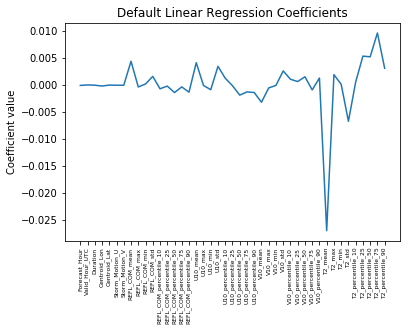

In [586]:
print('Linear Regression Coefficients')
print(lm.coef_)
print(lm.intercept_)
fig = plt.figure(7)
ax = fig.add_subplot(111)
plt.plot(lm.coef_)
plt.title('Default Linear Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xticks(range(len(PREDICTORS)))
ax.set_xticklabels(PREDICTORS,rotation=90,fontsize=6)
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig7.png', bbox_inches='tight')
else:
    plt.show()

Now we'll make some in- and out-of-sample predictions with the model, and compare against a simple baseline.
For our simple baseline, we'll just have the baseline model predict the sample mean for every record.
Making predictions with a fitted model is also a simple process, requiring just one line of code.
All supervised learning models in scikit-learn implement, in addition to the aforementioned fit() method, a predict() method to generate predictions on new records. predict() cannot be called until fit() has already been executed for the model.

In [587]:
train_predictions = lm.predict(train_df)
test_predictions = lm.predict(test_df)
baseline_predictions_train = [np.mean(train_tar)]*len(train_predictions)
baseline_predictions_test = [np.mean(np.append(train_tar,test_tar,axis=0))]*len(test_predictions)

Now, let's calculate some error statistics for how our model performs. Two common error statistics for regression problems are Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE). These are both implemented within scikit-learn in the sklearn.metrics module. By comparing with our baseline, we can also calculate skill scores.

First, let's start with in-sample error/skill, also known as training error:

In [588]:
mae_train = sklearn.metrics.mean_absolute_error(train_tar, train_predictions)
rmse_train = np.sqrt(sklearn.metrics.mean_squared_error(train_tar, train_predictions))
mae_train_base = sklearn.metrics.mean_absolute_error(train_tar, baseline_predictions_train) 
rmse_train_base = np.sqrt(sklearn.metrics.mean_squared_error(train_tar, baseline_predictions_train))
mae_ss_train, rmse_ss_train = calc_ss(mae_train, mae_train_base), calc_ss(rmse_train, rmse_train_base)

..And now for Out-of-sample/Test Error/Skill:

In [589]:
mae_test = sklearn.metrics.mean_absolute_error(test_tar, test_predictions)
rmse_test = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, test_predictions))
mae_test_base = sklearn.metrics.mean_absolute_error(test_tar, baseline_predictions_test)
rmse_test_base = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, baseline_predictions_test))
mae_ss_test, rmse_ss_test = calc_ss(mae_test, mae_test_base), calc_ss(rmse_test, rmse_test_base)

print('In-Sample error stats (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_train, rmse_train))
print('In-Sample baseline stats (MAE; RMSE): {}; {}'.format(mae_train_base, rmse_train_base))
print('In-Sample skill scores (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_ss_train, rmse_ss_train))
print('Out-of-Sample error stats (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_test, rmse_test))
print('Out-of-Sample baseline stats (MAE; RMSE): {}; {}'.format(mae_test_base, rmse_test_base))
print('Out-of-Sample skill scores (MAE; RMSE) for Linear Regression: {}; {}'.format(mae_ss_test, rmse_ss_test))

In-Sample error stats (MAE; RMSE) for Linear Regression: 0.004092042141680351; 0.005377999568610809
In-Sample baseline stats (MAE; RMSE): 0.006428745018717546; 0.00877312853951479
In-Sample skill scores (MAE; RMSE) for Linear Regression: 0.36347729926039873; 0.386991818894717
Out-of-Sample error stats (MAE; RMSE) for Linear Regression: 0.00491240004504727; 0.006722705443856907
Out-of-Sample baseline stats (MAE; RMSE): 0.0062060799481717934; 0.008429657316586112
Out-of-Sample skill scores (MAE; RMSE) for Linear Regression: 0.20845363158842645; 0.20249362561519824


You can see, perhaps unsurprisingly, that In-Sample verification paints a different (better) quantitative results than Out-of-Sample verification.
This is a result of *overfitting*.
Overfitting in regression models is combatted through a technique known as *regularization*.

We will now look at modified (regularized) linear regression models, and see how in-sample testing is often misleading.
    
First, we will repeat this exercise with standardized predictors and predictand.
Some machine learning algorithms are not *scale-invariant*; that is, they depend on the quantitative magnitude of the predictors (or predictand). When dealing with predictors with different scales or different units, this can inadvertently result in some predictors unduly influencing the model's structure compared with others. This is generally combatted by *standardizing* the predictors so that they all have the same scale and are unitless.

Scikit-learn provides built-in capability for this kind of pre- (and post-) processing in the sklearn.preprocessing module.

In [590]:
scaler = sklearn.preprocessing.StandardScaler()
scaler_tar = sklearn.preprocessing.StandardScaler()
train_df_std = scaler.fit_transform(train_df)
test_df_std = scaler.transform(test_df)
train_tar_std = scaler_tar.fit_transform(np.expand_dims(train_tar, axis=1))[:,0]
test_tar_std = scaler_tar.transform(np.expand_dims(test_tar, axis=1))[:,0]

lm_std = train_linear(train_df_std, train_tar_std)    
test_predictions_std = lm_std.predict(test_df_std)   

The scaler retains the mean/standard deviation information from the *training sample* which is used for constructing the model. It is necessary to keep it around for transforming test or validation examples in future scenarios rather than using the validation or test sample mean/std. dev. for transforming the predictors.

Ultimately, we want to make our predictions in physical space, and not in the physically-insignificant standardized space. We need to transform back into physical space.

In [591]:
test_predictions_std = scaler_tar.inverse_transform(test_predictions_std)

By construction, the intercept should be very nearly zero, and the coefficients have the same units and are thus qualitatively comparable. The verification statistics should be identical to the non-standardized regression.

In [592]:
print(lm_std.coef_)
print(lm_std.intercept_)
 
mae_test_std = sklearn.metrics.mean_absolute_error(test_tar, test_predictions_std)
rmse_test_std = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, test_predictions_std))
mae_ss_test_std, rmse_ss_test_std = calc_ss(mae_test_std, mae_test_base), calc_ss(rmse_test_std, rmse_test_base)

print('Out-of-Sample error stats (MAE; RMSE) for Standardized Linear Regression: {}; {}'.format(mae_test_std, rmse_test_std))
print('Out-of-Sample skill scores (MAE; RMSE) for Standardized Linear Regression: {}; {}'.format(mae_ss_test_std, rmse_ss_test_std))

[-2.35271975e-02  4.91708974e-02  1.23054972e-03 -1.98812943e-01
  1.53128338e-02 -1.17786347e-02 -7.11964714e-02  2.07320645e+00
 -2.93791523e-01  6.09349843e-02  3.80092438e-01 -2.06791558e-01
 -5.83677813e-02 -6.33876871e-01 -1.92155548e-01 -9.56924137e-01
  2.11944209e+00 -2.84561997e-02 -4.47140573e-01  5.39913091e-01
  6.66303573e-01 -4.65439460e-02 -9.45127977e-01 -6.73936537e-01
 -7.74829625e-01 -1.49044709e+00 -2.86857182e-01 -1.86640312e-02
  4.40938008e-01  5.74203232e-01  3.37467306e-01  7.54751388e-01
 -4.27398477e-01  6.92585710e-01 -2.01300128e+01  1.51162340e+00
  1.31510840e-01 -4.79260049e-01  4.42493884e-01  4.01122964e+00
  3.92059431e+00  7.30160397e+00  2.40343830e+00]
-1.3878641526159274e-13
Out-of-Sample error stats (MAE; RMSE) for Standardized Linear Regression: 0.004912400045047057; 0.006722705443856777
Out-of-Sample skill scores (MAE; RMSE) for Standardized Linear Regression: 0.20845363158846075; 0.20249362561521367


Now we're ready to look at regularization. We'll start with Ridge Regression, which uses L2 Regularization. This penalizes the sum of the squares of weights, which in effect penalizes large weights. Consequently, the model extrapolates less from the training data supplied, and is instead drawn towards the baseline model which does not use the predictors at all (in effect has a weight vector of all zeros). The extent of this penalization can be controlled with a regularization parameter, termed 'alpha' in scikit-learn.

In [593]:
ridge_lm = train_linear(train_df_std, train_tar_std, alpha=1, l1_ratio=0)
print(ridge_lm.coef_)

ridge_predictions_train = scaler_tar.inverse_transform(ridge_lm.predict(train_df_std))
ridge_predictions = scaler_tar.inverse_transform(ridge_lm.predict(test_df_std))

mae_train_ridge = sklearn.metrics.mean_absolute_error(train_tar, ridge_predictions_train)
rmse_train_ridge = np.sqrt(sklearn.metrics.mean_squared_error(train_tar, ridge_predictions_train))
mae_ss_train_ridge, rmse_ss_train_ridge = calc_ss(mae_train_ridge, mae_train_base), calc_ss(rmse_train_ridge, rmse_train_base)

mae_test_ridge = sklearn.metrics.mean_absolute_error(test_tar, ridge_predictions)
rmse_test_ridge = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, ridge_predictions))
mae_ss_test_ridge, rmse_ss_test_ridge = calc_ss(mae_test_ridge, mae_test_base), calc_ss(rmse_test_ridge, rmse_test_base)

print('In-Sample error stats (MAE; RMSE) for Ridge Regression: {}; {}'.format(mae_train_ridge, rmse_train_ridge))
print('In-Sample skill scores (MAE; RMSE) for Ridge Regression: {}; {}'.format(mae_ss_train_ridge, rmse_ss_train_ridge))
print('Out-of-Sample error stats (MAE; RMSE) for Ridge Regression: {}; {}'.format(mae_test_ridge, rmse_test_ridge))
print('Out-of-Sample skill scores (MAE; RMSE) for Ridge Regression: {}; {}'.format(mae_ss_test_ridge, rmse_ss_test_ridge))

[-0.03246338  0.04469393 -0.00430129 -0.21162305  0.01410471 -0.00897181
 -0.06666278  0.38979908 -0.18264698  0.08246632  0.34308738 -0.01406964
  0.15425515 -0.16736932  0.22096261 -0.53105254  0.04112287  0.23726118
 -0.37178605  0.09093541  0.42382323  0.15131435 -0.15894757 -0.28868827
  0.01454353  0.07999474 -0.21917385 -0.10879666  0.24809172  0.2332966
 -0.07347657  0.18538481 -0.33681424  0.29026623 -0.15754996 -0.09766571
  0.07983184  0.06761005 -0.75765563 -0.27590478 -0.06182906  1.00144165
 -0.30049987]
In-Sample error stats (MAE; RMSE) for Ridge Regression: 0.0041511545374723294; 0.005525405896170226
In-Sample skill scores (MAE; RMSE) for Ridge Regression: 0.3542822859848884; 0.3701897936085846
Out-of-Sample error stats (MAE; RMSE) for Ridge Regression: 0.004821676034377812; 0.006555708459910412
Out-of-Sample skill scores (MAE; RMSE) for Ridge Regression: 0.22307220102792968; 0.2223042748118047


We arbitrarily picked a value of alpha, but is this best? Let's find out by testing alternate values.
In some cases (including this one), we can have sklearn do this automatically, but let's do it manually first to see the steps.

In [594]:
cand_alphas = np.logspace(-10, 10, 21)
train_rmses = []; cv_rmses = []
all_coefs = []
best_ridge = None
n_folds = 3
cand_ridge_lms = []
for ca in cand_alphas:
    train_rmses.append(0); cv_rmses.append(0)
    for fold in range(n_folds):
        train_df_std_fold, val_df_std_fold, train_tar_std_fold, val_tar_std_fold = partition_data(train_df_std, train_tar_std, n_folds, fold)
        lm_ca_ridge = train_linear(train_df_std_fold, train_tar_std_fold, alpha=ca, l1_ratio=0)
        if fold == 0:
            cand_ridge_lms.append(lm_ca_ridge)
        preds = lm_ca_ridge.predict(val_df_std_fold)
        ca_ridge_predictions_train = (lm_ca_ridge.predict(train_df_std_fold))
        ca_ridge_predictions = (lm_ca_ridge.predict(val_df_std_fold))
        rmse_train_ridge = np.sqrt(sklearn.metrics.mean_squared_error(train_tar_std_fold, ca_ridge_predictions_train))
        rmse_test_ridge = np.sqrt(sklearn.metrics.mean_squared_error(val_tar_std_fold, ca_ridge_predictions))
        train_rmses[-1] = train_rmses[-1] + rmse_train_ridge
        cv_rmses[-1] = cv_rmses[-1] + rmse_test_ridge
    train_rmses[-1] = train_rmses[-1] / (n_folds - 1)
best_ind = (np.where(cv_rmses == np.min(cv_rmses))[0][0])
best_alpha = cand_alphas[best_ind]    
best_ridge_lm = train_linear(train_df_std, train_tar_std, alpha=best_alpha, l1_ratio=0)
all_rmses = np.append(np.expand_dims(train_rmses,axis=0), np.expand_dims(cv_rmses,axis=0), axis=0)
print('Coefficients with tuned regularization parameter:')
print(best_ridge_lm.coef_)

Coefficients with tuned regularization parameter:
[-0.02920493  0.03675623 -0.00091323 -0.18362127  0.02728784 -0.00852292
 -0.05030561  0.04025132 -0.00729082  0.04635167  0.01013149  0.03011508
  0.05054426  0.03303777  0.05114446  0.00304876  0.00812111  0.05688505
 -0.03668828  0.05459702  0.00155739  0.0060956  -0.0002354   0.00238313
  0.0293086   0.01090587  0.03635762 -0.03548986  0.07360347 -0.01538763
 -0.00874258  0.0150421   0.01893651  0.0412291  -0.0716437  -0.05001263
 -0.07535817  0.14164606 -0.10128309 -0.08823412 -0.07305719 -0.04005657
 -0.05151037]


We can visualize the effect of alpha on the regression coefficients:

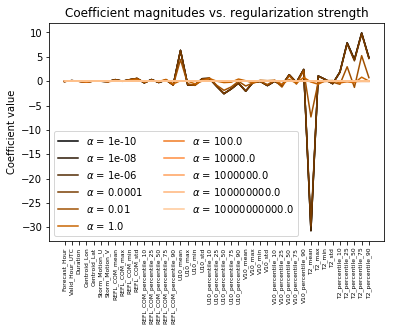

In [595]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
all_coefs = np.zeros((len(cand_alphas[::2]),len(PREDICTORS)))
colors = []
for i in range(0,len(cand_alphas),2):
    all_coefs[int(i/2),:] = cand_ridge_lms[i].coef_
    colors.append(np.array([min(255, 40*(i/2)), min(255, 20*(i/2)), min(255,max(0, 30*((i/2)-5)))])/255.)
    plt.plot(cand_ridge_lms[i].coef_, color=colors[-1])
plt.title('Coefficient magnitudes vs. regularization strength')
plt.ylabel('Coefficient value')
plt.xticks(range(len(PREDICTORS)))
ax.set_xticklabels(PREDICTORS,rotation=90,fontsize=6)
plt.legend([r'$\alpha$' + ' = %s' % alph for alph in cand_alphas[::2]], ncol=2, loc='lower left')
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig1.png', bbox_inches='tight')
else:
    plt.show()

You'll notice the coefficients gravitate towards zero as regularization strength (alpha) increases.

We can also visualize the effect of alpha on training and validation error:

[[0.84318712 0.84318712 0.84318712 0.84318712 0.84318712 0.84318721
  0.84319524 0.84369159 0.8487792  0.86016534 0.89349166 0.93859012
  0.97154604 1.12145002 1.40118578 1.4843564  1.49439374 1.49541852
  1.49552121 1.49553148 1.49553251]
 [2.73654567 2.73654567 2.73654562 2.73654517 2.73654064 2.73649569
  2.73607414 2.73346777 2.71163994 2.57622157 2.38016863 2.2467274
  2.16636698 2.36206641 2.8451325  2.98316088 2.999597   3.00127235
  3.00144021 3.001457   3.00145868]]


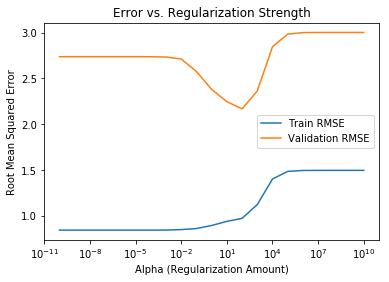

In [596]:
plt.figure(2)
plt.semilogx(cand_alphas, np.transpose(all_rmses))
print(all_rmses)
plt.legend(['Train RMSE', 'Validation RMSE'])
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Root Mean Squared Error')
plt.title('Error vs. Regularization Strength')
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig2.png')
else:
    plt.show()

You'll notice a number of things about this simple plot:

1. Training error is consistently lower than validation/test error, though they get closer together as regularization strength increases.
2. Training error consistently increases as regularization strength increases.
3. In contrast, validation/test error often decreases as regularization strength increases for a time, reaches a minimum, and then increases with increasing regularization thereafter. We want to identify this regularization strength tha minimizes test error, and the steps above were conducted to identify this optimal value of alpha. This error minimization comes from a tradeoff of bias error and variance error, known as the bias/variance tradeoff, discussed in more detail in the module notes.
4. Regularization can give you better performance than unregularized regression.
5. In-sample error is not predictive of out-of-sample error.

Sticking with basic linear regression for now, have we built the most skillful model we can, or is there still room for improvement?

Let's examine an alternative kind of regularization: L1 regularization, also known as LASSO.

This time, we'll look at how to do the parameter tuning automatically:

In [597]:
best_lasso_lm = sklearn.linear_model.LassoCV(alphas=cand_alphas, cv=4)
best_lasso_lm.fit(train_df_std, train_tar_std)
best_alpha_lasso = best_lasso_lm.alpha_
print('Regression coefficients for tuned LASSO:')
print(best_lasso_lm.coef_)

best_ridge_predictions = scaler_tar.inverse_transform(best_ridge_lm.predict(test_df_std))
best_lasso_predictions = scaler_tar.inverse_transform(best_lasso_lm.predict(test_df_std))
rmse_test_bridge = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, best_ridge_predictions))
rmse_test_blasso = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, best_lasso_predictions))
rmse_ss_test_bridge = calc_ss(rmse_test_bridge, rmse_test_base); rmse_ss_test_blasso = calc_ss(rmse_test_blasso, rmse_test_base)
print('Out-of-Sample stats (RMSE; RMSESS) for Unregularized Regression: {}; {}'.format(rmse_test_std, rmse_ss_test_std))
print('Out-of-Sample stats (RMSE; RMSESS) for Best Ridge Regression: {}; {}'.format(rmse_test_bridge, rmse_ss_test_bridge))
print('Out-of-Sample stats (RMSE; RMSESS) for Best LASSO Regression: {}; {}'.format(rmse_test_blasso, rmse_ss_test_blasso))

Regression coefficients for tuned LASSO:
[-0.0220337   0.03441476 -0.         -0.22406224  0.01019524 -0.
 -0.05027181  0.         -0.          0.05021628  0.          0.
  0.10553075  0.          0.10775843 -0.         -0.          0.07082503
 -0.00902785  0.05828228 -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.11032721  0.
  0.          0.          0.          0.06808538 -0.         -0.
 -0.          0.129357   -0.55552072 -0.         -0.          0.
 -0.        ]
Out-of-Sample stats (RMSE; RMSESS) for Unregularized Regression: 0.006722705443856777; 0.20249362561521367
Out-of-Sample stats (RMSE; RMSESS) for Best Ridge Regression: 0.006425599812282185; 0.2377389055140786
Out-of-Sample stats (RMSE; RMSESS) for Best LASSO Regression: 0.006477042069774365; 0.231636373043279


L1 and L2 regularization can also be combined in the same regression model. This is called Elastic Net.
In Elastic Net, in addition to the overall regularization strength, the proportion of regularization in L1 vs. L2 can be controlled with an additional parameter: l1_ratio (0-1; 0 all L2, 1 all L1).

Like with alpha and the LASSO, these two parameters can be automatically tuned in tandem with sklearn via grid search cross-validation:

In [598]:
cand_l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
best_en_lm = sklearn.linear_model.ElasticNetCV(l1_ratio=cand_l1_ratios, alphas=cand_alphas)
best_en_lm.fit(train_df_std, train_tar_std)
best_en_predictions = scaler_tar.inverse_transform(best_en_lm.predict(test_df_std))
rmse_test_ben = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, best_en_predictions))
rmse_ss_test_ben = calc_ss(rmse_test_ben, rmse_test_base)
print('Out-of-Sample stats (RMSE; RMSESS) for Best Elastic Net Regression: {}; {}'.format(rmse_test_ben, rmse_ss_test_ben))

Out-of-Sample stats (RMSE; RMSESS) for Best Elastic Net Regression: 0.006442847504644255; 0.23569283273622865


Let's look at how the regression coefficients for different kinds of regularization (or lack thereof) compare:

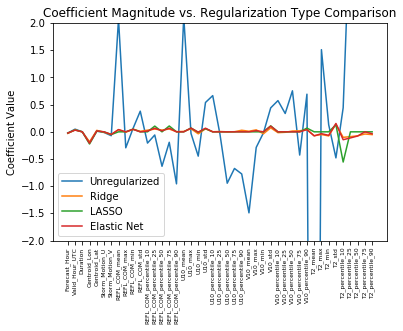

In [599]:
coef_comp = np.zeros((4, len(PREDICTORS)))
coef_comp[0,:] = lm_std.coef_; coef_comp[1,:] = best_ridge_lm.coef_
coef_comp[2,:] = best_lasso_lm.coef_; coef_comp[3,:] = best_en_lm.coef_
fig = plt.figure(3)
ax = fig.add_subplot(111)
plt.title('Coefficient Magnitude vs. Regularization Type Comparison')
plt.ylabel('Coefficient Value')
plt.xticks(range(len(PREDICTORS)))
ax.set_xticklabels(PREDICTORS,rotation=90,fontsize=6)
[plt.plot(coef_comp[i,:]) for i in range(coef_comp.shape[0])]
plt.ylim([-2, 2])
plt.legend(['Unregularized', 'Ridge', 'LASSO', 'Elastic Net'])
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig3.png', bbox_inches='tight')
else:
    plt.show()

Regularization is a way of reducing *variance* in a regression model.
Variance reduction can also be attained in pre-processing.
Two classes of methods that do so are feature extraction and feature selection.
Let's take a quick look at feature extraction.
 
Broadly speaking, feature extraction is the process of deriving new features from existing ones.
Feature extraction is often used as a means of dimensionality reduction: finding a smaller feature set that encompasses the vast majority of the signal/variance in the training set while (hopefully) removing most of the statistical noise.
One common and straightforward dimensionality reduction technique is Principal Component Analysis (PCA).
Let's take a look at the process of using PCA in pre-processing for dimensionality reduction & feature extraction.
    
PCA is a kind of unsupervised learning; it learns structure from unlabeled training data.
PCA is also scale-dependent, so it is paramount that the supplied features are already standardized, unless you want certain features emphasized relative to others in the dimensionality reduction phase. Typically, it's best to just leave this to the machine learning algorithm to determine.

Performing dimensionality reduction often introduces one or more tunable parameters that can affect the final features that are subsequently supplied to the learning algorithm. As with the tunable parameters themselves, it is best to tune these parameters through (cross-)validation, in conjunction with any tunable parameters in the learning model.
In the case of PCA, the one tunable parameter is the number of retained components. 
There are some heuristics that can be followed, but it is best when possible to follow normal procedure and experiment with different values.

In [600]:
pca = sklearn.decomposition.PCA()

train_df_pca = pca.fit_transform(train_df_std)
test_df_pca = pca.transform(test_df_std)

cand_frac_expl = [0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
frac_expl_by_pc = pca.explained_variance_ratio_
cumfrac_expl_by_pc = np.cumsum(frac_expl_by_pc) 
cand_n_comps = [int(1+np.where(cumfrac_expl_by_pc >= cfe)[0][0]) for cfe in cand_frac_expl]
print('Candidate number of components:')
print(cand_n_comps)

Candidate number of components:
[1, 2, 3, 4, 5, 6, 7, 9]


Tuning for these parameters is not built in to any sklearn function.
Re-implementing a full grid search is rather straightforward, but can become expensive as the training dataset size and/or number of tuned parameters increases.

We will walk through an implementation of "greedy" tuning, which is likely but not certain to arrive at the optimal parameter configuration, and do so in far fewer experiments.

In [601]:
n_comp_ind = int(len(cand_n_comps)/2)
l1_ratio_ind = int(len(cand_l1_ratios)/2)
alpha_ind = int(len(cand_alphas)/2)
    
tune_ncomp = None; tune_alpha = None; tune_l1r = None
n_folds = 3
all_rmses = np.ones((len(cand_n_comps),len(cand_l1_ratios),len(cand_alphas)))*DEFAULT_VALUE
axis = 0
inds = [n_comp_ind, l1_ratio_ind, alpha_ind]
bound_below = -1; bound_above = -1
while axis < all_rmses.ndim:
    n_comp_ind = inds[0]; l1_ratio_ind = inds[1]; alpha_ind = inds[2]
    train_df_pca_tmp = train_df_pca[:,0:cand_n_comps[n_comp_ind]]
    alpha = cand_alphas[alpha_ind]
    l1_ratio = cand_l1_ratios[l1_ratio_ind]
    model = sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    for fold in range(n_folds):
        train_df_pca_tmp_fold, val_df_pca_tmp_fold, train_tar_std_fold, val_tar_std_fold = partition_data(train_df_pca_tmp, train_tar_std, n_folds, fold) 
        model.fit(train_df_pca_tmp_fold, train_tar_std_fold)
        preds = model.predict(val_df_pca_tmp_fold)
        all_rmses[n_comp_ind, l1_ratio_ind, alpha_ind] += np.sqrt(sklearn.metrics.mean_squared_error(val_tar_std_fold, preds))
    tmp_inds = np.copy(inds)
    tmp_inds[axis] = tmp_inds[axis]+1
    if inds[axis] == all_rmses.shape[axis]-1:
        bound_above = inds[axis]
    elif np.take(all_rmses, fancy_ind(inds, all_rmses.shape)) > np.take(all_rmses, fancy_ind(tmp_inds, all_rmses.shape)) and np.take(all_rmses, fancy_ind(tmp_inds, all_rmses.shape)) < DEFAULT_VALUE:
        bound_below = inds[axis]+1
    tmp_inds = np.copy(inds)
    tmp_inds[axis] = tmp_inds[axis]-1
    if inds[axis] == 0:
        bound_below = inds[axis]
    elif np.take(all_rmses, fancy_ind(inds, all_rmses.shape)) > np.take(all_rmses, fancy_ind(tmp_inds, all_rmses.shape)) and  np.take(all_rmses, fancy_ind(tmp_inds, all_rmses.shape)) < DEFAULT_VALUE:
        bound_above = inds[axis]-1
        inds[axis] = np.where(np.take(all_rmses, range(len(all_rmses.shape[axis])), axis=axis) < DEFAULT_VALUE)[0][-1]
    if bound_above >= 0 and bound_below >= 0:
        n_comp_ind = np.where(all_rmses[bound_below:bound_above, l1_ratio_ind, alpha_ind] == np.min(all_rmses[bound_below:bound_above, l1_ratio_ind, alpha_ind]))[0][0] + bound_below
        cand_rmses = all_rmses
        for ax in range(len(inds)-1,-1,-1):
            if ax != axis:
                cand_rmses = np.take(cand_rmses, inds[ax], axis=ax)
        cand_rmses = np.take(cand_rmses, range(bound_below, bound_above+1), axis=0)
        inds[axis] = bound_below + np.where(cand_rmses == np.min(cand_rmses))[0][0]
        axis += 1
        bound_below = -1
        bound_above = -1
    elif bound_above >= 0:
        inds[axis] = inds[axis] - 1
    else:
        inds[axis] = inds[axis] + 1

We can now train a final model and evaluate its performance:

In [602]:
train_df_pca_tmp = train_df_pca[:,0:cand_n_comps[inds[0]]]
alpha = cand_alphas[inds[2]]
l1_ratio = cand_l1_ratios[inds[1]]
pca_model = sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
pca_model.fit(train_df_pca_tmp, train_tar_std)
best_en_pca_predictions = scaler_tar.inverse_transform(pca_model.predict(test_df_pca[:,0:cand_n_comps[inds[0]]]))
rmse_test_bpca = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, best_en_pca_predictions))
rmse_ss_test_bpca = calc_ss(rmse_test_bpca, rmse_test_base)
print('Best Parameters: #PCs: {}; Alpha: {}; L1 ratio: {}'.format(cand_n_comps[inds[0]], alpha, l1_ratio))
print('Out-of-Sample stats (RMSE; RMSESS) for Best EN PCA Regression: {}; {}'.format(rmse_test_bpca, rmse_ss_test_bpca))

Best Parameters: #PCs: 4; Alpha: 1e-10; L1 ratio: 0.1
Out-of-Sample stats (RMSE; RMSESS) for Best EN PCA Regression: 0.006571779648972543; 0.2203977691902168


Let's move on to Classification.
As discussed in the notes, Classification is used for categorical or discrete predictands.
Classification models supply probabilities for each possible predictand outcome. 
Any Regression task can be converted to a Classification problem; the opposite is not true.
Let's start simple with a binary (2-category) extension of the same prediction task we've been focusing on.
Suppose we're interested in storms that produce non-trivial hail sizes of at least 0.01 m.
We can discretize our predictand into examples that exceed that threshold and those that do not.

We'll begin with the Classification analogy to Linear Regression for Regression which, confusingly, is known as Logistic Regression.

First, we need to convert our predictand.

In [603]:
train_tar_2cat = np.where(train_tar >= CRIT_THRESH, 1, 0)
test_tar_2cat = np.where(test_tar >= CRIT_THRESH, 1, 0)
clim_prob = (np.sum(train_tar_2cat)+np.sum(test_tar_2cat))/(len(train_tar_2cat)+len(test_tar_2cat))

Like Linear Regression, Logistic Regression can be regularized (or not).
In sklearn currently, either L1 or L2 regularization are supported, but not both simultaneously.
Let's stick with L2 regularization for now.
The regularization parameter in sklearn's LogisticRegression is C, which is an *inverse* of 
regularization strength; i.e. larger numbers mean less regularization.
There is a built-in method which will tune C via cross-validation: LogisticRegressionCV.
We'll make use of that.

In [604]:
log_reg = sklearn.linear_model.LogisticRegressionCV(Cs=21, penalty='l2')
log_reg.fit(train_df_std, train_tar_2cat)

LogisticRegressionCV(Cs=21, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Logistic regression models can be interpreted in a very similar way to LinearRegression:

Logistic Regression Coefficients:
[[-0.02599193  0.08634217  0.05213973 -0.3791732   0.18453034  0.06755886
  -0.12139682  0.13097368  0.07519595  0.04089745  0.08759141  0.10791998
   0.1529322   0.13026249  0.1243687   0.10001754  0.04301193  0.10601657
  -0.00993778  0.12482317 -0.00042525  0.01506862  0.02954705  0.06458442
   0.0828152   0.01813681  0.05906981 -0.07790806  0.12106389 -0.03658424
  -0.00050234  0.03575687  0.03967195  0.06465963 -0.20648859 -0.17395466
  -0.233569    0.16371353 -0.24029907 -0.21939985 -0.19921337 -0.19013681
  -0.18580167]]
[-2.37526455]


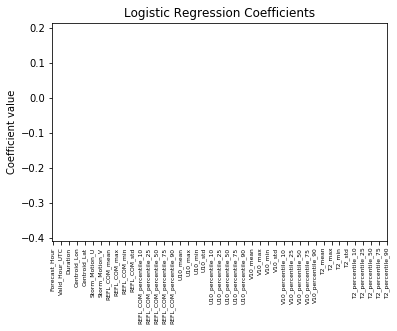

In [605]:
print('Logistic Regression Coefficients:')
print(log_reg.coef_)
print(log_reg.intercept_)
fig = plt.figure(8)
ax = fig.add_subplot(111)
plt.plot(log_reg.coef_)
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xticks(range(len(PREDICTORS)))
ax.set_xticklabels(PREDICTORS,rotation=90,fontsize=6)
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig8.png', bbox_inches='tight')
else:
    plt.show()

In sklearn, like with Regression models, Classification algorithms have a predict() method.
For Classification methods, this just gives the most likely (modal) verification in each class.

In [606]:
det_logreg_preds = log_reg.predict(test_df_std)

This is generally not the best way to use a classification model, nor is it typically the best way to evaluate such a model.

One common and usually more robust way to verify a classification model is via the Brier Score.
This is implemented in sklearn.
Like with many error measures, 0 is a perfect Brier Score, and larger values are worse.
or the Brier score, you actually use the model's event probabilities for verification, rather than just the most likely outcome.
Probabilities can be obtained for any Classification algorithm in sklearn by using the predict_proba() method in the class.

In [607]:
prob_logreg_preds = log_reg.predict_proba(test_df_std)
brier_score_logreg = sklearn.metrics.brier_score_loss(test_tar_2cat, prob_logreg_preds[:,1])
brier_score_base = sklearn.metrics.brier_score_loss(test_tar_2cat, np.ones(len(test_tar_2cat))*clim_prob)
bss_logreg = calc_ss(brier_score_logreg, brier_score_base)
print('Best Logistic Regression Parameters: C: {}'.format(log_reg.C_))
print('Out-of-Sample stats (BS; BSS) for Logistic Regression Classification: {}; {}'.format(brier_score_logreg, bss_logreg))

Best Logistic Regression Parameters: C: [0.02511886]
Out-of-Sample stats (BS; BSS) for Logistic Regression Classification: 0.0918671728291951; 0.390134175731883


One rather common situation in classification is to have a considerably imbalance between the event classes.
Typically, one is interested in predicting a high-impact event (like tornado occurrence), which is often rare and then by definition, occurs much more infrequently than the non-event class.
By default, training a model results in it seeing many more instances of the non-event class compared with the event class.
In these situations, oftentimes developers find they get better model performance when they systematicall oversample (undersample) the event (non-event) class so that the frequency is more even. This modification can be readily performed in sklearn:

In [608]:
log_reg_bal = sklearn.linear_model.LogisticRegressionCV(Cs=21, penalty='l2', class_weight='balanced')
log_reg_bal.fit(train_df_std, train_tar_2cat)
prob_logreg_bal_preds = log_reg_bal.predict_proba(test_df_std)
brier_score_logreg_bal = sklearn.metrics.brier_score_loss(test_tar_2cat, prob_logreg_bal_preds[:,1])
bss_logreg_bal = calc_ss(brier_score_logreg_bal, brier_score_base)
print('Out-of-Sample stats (BS; BSS) for Balanced Logistic Regression Classification: {}; {}'.format(brier_score_logreg_bal, bss_logreg_bal))

Out-of-Sample stats (BS; BSS) for Balanced Logistic Regression Classification: 0.11977952450640539; 0.20483632843083255


Many classification algorithms are originally designed for a binary prediction task like this one (tornado/no tornado).
But almost all can be adapted (to varying degrees) for multi-category prediction tasks.

Suppose you're still interested in the 0.1 over/under for the tornado/no tornado prediction task, but you don't feel you have enough resolution in the 'no tornado' class to have a good sense of storm impacts.
You can alleviate this challenge while remaining in a Classification setting by simply adding a second threshold.
In this case, suppose we consider hail over 0.001 m in size to distinguish between the existence and non-existence of hail in a storm within the "non-significant hail" category.

The appropriate 3-category predictand can be derived with relative ease:

In [609]:
train_tar_3cat = np.where(train_tar >= CRIT_THRESH, 2, np.where(train_tar >= CRIT_THRESH2, 1, 0))
test_tar_3cat = np.where(test_tar >= CRIT_THRESH, 2, np.where(test_tar >= CRIT_THRESH2, 1, 0))
log_reg_3cat = sklearn.linear_model.LogisticRegressionCV(Cs=21, penalty='l2', multi_class='multinomial')
log_reg_3cat.fit(train_df_std, train_tar_3cat)
clim_prob0 = float((len(np.where(train_tar_3cat == 0)[0]) + len(np.where(test_tar_3cat == 0)[0])))/float((len(train_tar)+len(test_tar)))
clim_prob1 = float((len(np.where(train_tar_3cat == 1)[0]) + len(np.where(test_tar_3cat == 1)[0])))/float((len(train_tar)+len(test_tar)))
clim_prob2 = 1. - clim_prob0 - clim_prob1
clim_probs_3cat = np.array([clim_prob0, clim_prob1, clim_prob2])
print('Climatological Probabilities (3-category): {}'.format(clim_probs_3cat))

Climatological Probabilities (3-category): [0.73398806 0.08127508 0.18473686]


The Brier score is fundamentally designed for a 2-category problem, but is readily extended to the (ordinal) multi-category case via the Rank Probability Score.
This is not currently implemented in sklearn, so we must define it ourselves.
This was implemented above in Cell 13.

In [610]:
log_reg_3cat_preds = log_reg_3cat.predict_proba(test_df_std)
clim_probs_3cat_test = np.ones(log_reg_3cat_preds.shape)*clim_probs_3cat
rps_log_reg_3cat = rank_probability_score(test_tar_3cat, log_reg_3cat_preds)
rps_base = rank_probability_score(test_tar_3cat, clim_probs_3cat_test)
rpss = calc_ss(rps_log_reg_3cat, rps_base)
print('Out-of-Sample stats (RPS; RPSS) for  3-Category Logistic Regression Classification: {}; {}'.format(rps_log_reg_3cat, rpss))

Out-of-Sample stats (RPS; RPSS) for  3-Category Logistic Regression Classification: 5646.564965310153; 0.4611669650041431


So far, we have only looked at linear models -- those algorithms which impose a linear relationship (perhaps transformed through a non-linear link function, as in the case of Logistic Regression) between the predictors and the predictand.

This is a serious limitation, though perhaps not quite as strong of an imposition as it may initially seem.
First, the structural imposition is that there is a linear relationship between the predictand and each *predictor*, not each underlying variable. For example, if trying to predict distance traveled after 10 seconds given initial predictors of initial velocity and (known constant) acceleration, it would not be possible to back out distance traveled exactly from the raw velocity and acceleration predictors themselves using a linear model. However, by simply changing the predictors to velocity and acceleration^2, the linear assumption is valid and the distance traveled may be exactly computed.
Second, the *predictors* are treated entirely independent, but not the underlying variables. For example, one predictor can be the product, quotient, or some complex function of two or more variables.
Nevertheless, oftentimes we don't know exactly how the predictors relate to the predictand and/or how the predictors interrelate. If we did, the prediction task would in general be quite straightforward! 
So the linear assumption does in effect pose a major restriction on the relationships between the supplied data.

Often we wish to not impose assumptions that we don't know or have particular reason to believe to be true, and would rather instead develop a more general model which does not impose such rigid assumptions.
One example of such a model is the Decision Tree.
The Decision Tree can be used for both Regression and Classification.
Decision Trees are also scale-invariant, and all tree-based algorithms should not be affected by whether predictors were standardized.

In [611]:
dec_tree_reg_default = sklearn.tree.DecisionTreeRegressor()
dec_tree_class_default = sklearn.tree.DecisionTreeClassifier()
dec_tree_reg_default.fit(train_df, train_tar)
dec_tree_class_default.fit(train_df, train_tar_2cat)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Decision Trees lack regression coefficients to easily interpret predictor-predictand relationships (although even those require care in interpretation). Instead, there are a number of ways to interpret Decision Tree models, some of which will be discussed in more detail later in the course; one of the simplest and most common approaches is through the so-called feature or variable importances.
For now, know that each feature/predictor has an associated feature importance -- a normalized value between 0 and 1 -- where an importance of zero indicates that the feature has no impact on the prediction, and a value of 1 means it completely determines the model's prediction.

If we want more detailed information about the tree structure, that can be obtained with the 'tree_' attribute of a DecisionTree. Printing of this info is implemented in Cell 10.

In [612]:
print('Decision Tree Regressor Feature Importances:')
print(dec_tree_reg_default.feature_importances_)
print('Decision Tree Classifier Feature Importances:')
print(dec_tree_class_default.feature_importances_)
print_tree_info(dec_tree_class_default)

dt_reg_def_preds = dec_tree_reg_default.predict(test_df)
dt_class_def_preds = dec_tree_class_default.predict_proba(test_df)
brier_score_dt_def = sklearn.metrics.brier_score_loss(test_tar_2cat, dt_class_def_preds[:,1])
bss_dt_def = calc_ss(brier_score_dt_def, brier_score_base)
rmse_test_dt_def = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, dt_reg_def_preds))
rmse_ss_test_dt_def = calc_ss(rmse_test_dt_def, rmse_test_base)
print('Out-of-Sample stats (RMSE; RMSESS) for Default Decision Tree Regression: {}; {}'.format(rmse_test_dt_def, rmse_ss_test_dt_def))
print('Out-of-Sample stats (BS; BSS) for Default Decision Tree Classification: {}; {}'.format(brier_score_dt_def, bss_dt_def))

Decision Tree Regressor Feature Importances:
[1.36348005e-03 9.74697562e-03 0.00000000e+00 4.83017713e-02
 2.76675051e-02 0.00000000e+00 1.23037152e-03 5.53941675e-03
 1.11003598e-02 4.84969340e-02 1.38845322e-03 1.18104623e-02
 1.23285026e-03 4.57087616e-03 3.15760098e-02 5.26381569e-03
 1.22946401e-05 1.48114611e-02 1.09384997e-03 1.67027748e-01
 1.89906645e-02 2.41008587e-03 2.04438806e-02 6.04220258e-05
 8.48717847e-03 0.00000000e+00 0.00000000e+00 7.59829399e-02
 5.60967547e-02 5.33145240e-03 1.09696245e-03 4.48975773e-02
 2.90480288e-03 1.51900093e-02 7.06618482e-04 7.87393392e-03
 3.03409974e-01 3.05015078e-03 1.81225695e-02 9.77701168e-04
 4.85562436e-04 1.97088598e-02 1.53726428e-03]
Decision Tree Classifier Feature Importances:
[0.01586333 0.         0.         0.14303846 0.01797255 0.
 0.01791021 0.         0.07379951 0.03265416 0.00829389 0.
 0.         0.         0.04968174 0.02392853 0.         0.04186157
 0.01722627 0.07717263 0.         0.         0.00902098 0.
 0.00887

There are a number of tunable parameters in a Decision Tree. Some concern how a split is made (e.g. 'criterion' and 'splitter', which determine how 'best' is determined and how that information is used, respectively), while most affect the termination criteria -- when to stop splitting and form a leaf; 'class_weight' also makes an appearance for a DecisionTreeClassifier. 
Fortunately, Decision Trees are less sensitive to parameter values than many other ML algorithms. Nevertheless, the values can still make a noticeable difference, and parameters should be properly tuned.
In the case of Decision Trees, the parameters are all interrelated, so picking a couple of representative parameters is sufficient.
The termination controlling parameters are: 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_leaf_nodes', and 'min_impurity_decrease'; you should tune at least one of these.
'criterion' does not have much material effect on model performance in my experience.
In some cases, 'max_features', which determines how many features to consider at each split opportunity, can impact performance.

Let's start by tuning just 'min_samples_split' and 'max_features'.
Other than the linear_model classes, most ML algorithms do not have built-in grid search cross-validation in sklearn, and it must instead be implemented manually. Last time, we implemented a manual greedy search; let's do a full grid search this time.

In [613]:
cand_min_samp_spls = [2, 4, 8, 16, 30, 60, 120, 250, 500, 1000]
cand_max_feats = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
all_briers = np.zeros((len(cand_max_feats), len(cand_min_samp_spls)))
for mf_ind in range(len(cand_max_feats)):
    mf = cand_max_feats[mf_ind]
    for mss_ind in range(len(cand_min_samp_spls)):
        mss = cand_min_samp_spls[mss_ind]
        dt = sklearn.tree.DecisionTreeClassifier(max_features=mf, min_samples_split=mss)
        for fold in range(n_folds):
            train_df_fold, val_df_fold, train_tar_2cat_fold, val_tar_2cat_fold = partition_data(train_df, train_tar_2cat, n_folds, fold)
            dt.fit(train_df_fold, train_tar_2cat_fold)
            preds = dt.predict_proba(val_df_fold)
            all_briers[mf_ind, mss_ind] += sklearn.metrics.brier_score_loss(val_tar_2cat_fold, preds[:,1])
mf_ind = np.where(all_briers == np.min(all_briers))[0][0]
mss_ind = np.where(all_briers == np.min(all_briers))[1][0]
mf = cand_max_feats[mf_ind]; mss = cand_min_samp_spls[mss_ind]
dt = sklearn.tree.DecisionTreeClassifier(max_features=mf, min_samples_split=mss)
dt.fit(train_df, train_tar_2cat)
preds = dt.predict_proba(test_df)
bs_dt_opt = sklearn.metrics.brier_score_loss(test_tar_2cat, preds[:,1])
bss_dt_opt = calc_ss(bs_dt_opt, brier_score_base)
print('Best Parameters: max_features: {}; min_samples_split: {}'.format(mf, mss))
print('Out-of-Sample stats (BS; BSS) for Tuned Decision Tree Classification: {}; {}'.format(bs_dt_opt, bss_dt_opt))

Best Parameters: max_features: 0.65; min_samples_split: 16
Out-of-Sample stats (BS; BSS) for Tuned Decision Tree Classification: 0.12664287355804746; 0.1592735675695417


The Decision Tree has the advantage over linear models in that it imposes fewer (incorrect) structural assumptions (i.e. it is less *biased* than linear models), but the structure learned is highly sensitive to the particular supplied training examples (i.e. it is high *variance*), and the structure may not always extrapolate well to records unseen in the training set.
For this reason, Decision Trees are infrequently used in isolation in modern studies and applications. 
    
Instead, a much more popular approach is the Random Forest.
The Random Forest uses a combination of approaches (described in course notes) to produce an ensemble many unique decision trees that can be used to make a single prediction. Technically, the steps to ensure unique decision trees result in a slight increase in *bias* in the model compared with a single decision tree in exchange for a larger decrease in model *variance*.

The Random Forest can also be applied to both Regression and Classification tasks.
As an ensemble of Decision Trees, the Random Forest shares almost all of its parameters with the DecisionTree classes.
The main added parameter, 'n_estimators', concerns the ensemble/forest *size*.
Unlike most parameters that have a Goldilocks value which maximizes skill, with forest size, skill tends to improve with diminishing returns with each added tree until skill plateaus, making the value a trade-off between skill and computational cost.

In [614]:
n_estimators = [5, 10, 25, 50, 100, 250, 500]
rf_bsss = np.zeros(len(n_estimators))
times = np.zeros(len(n_estimators))
for ne_ind in range(len(n_estimators)):
    start = time.time()
    ne = n_estimators[ne_ind] 
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=ne)
    rf.fit(train_df, train_tar_2cat)
    preds = rf.predict_proba(test_df)
    bs_rf = sklearn.metrics.brier_score_loss(test_tar_2cat, preds[:, 1])
    bss_rf = calc_ss(bs_rf, brier_score_base)
    rf_bsss[ne_ind] = bss_rf
    end = time.time()
    times[ne_ind] = end-start
print('Stats')
print("Times (s): {}".format(times))
print("BSS: {}".format(rf_bsss))

Stats
Times (s): [0.02400184 0.08458042 0.10604286 0.17031527 0.324898   0.80188274
 1.59939218]
BSS: [0.29940988 0.33430479 0.374943   0.38865529 0.39515356 0.39639215
 0.39444717]


<Figure size 432x288 with 0 Axes>

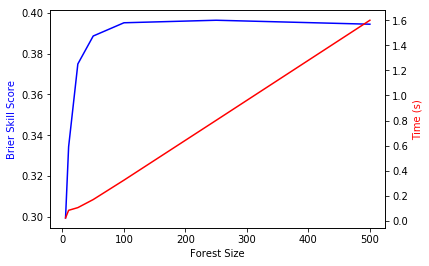

In [615]:
plt.figure(6)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('Forest Size')
ax1.set_ylabel('Brier Skill Score', color='b')
ax2.set_ylabel('Time (s)', color='r')
ax1.plot(n_estimators, rf_bsss, 'b')
ax2.plot(n_estimators, times, 'r')
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig6.png', bbox_inches='tight')
else:
    plt.show()

We still need to tune our RF parameters.
For now, we'll move forward with 10 estimators. We can increase the forest size at the end to increase predictive accuracy.

In [616]:
start = time.time()
all_briers_rf = np.zeros((len(cand_max_feats), len(cand_min_samp_spls)))
for mf_ind in range(len(cand_max_feats)):
    mf = cand_max_feats[mf_ind]
    for mss_ind in range(len(cand_min_samp_spls)):
        mss = cand_min_samp_spls[mss_ind]
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_features=mf, min_samples_split=mss)
        for fold in range(n_folds):
            train_df_fold, val_df_fold, train_tar_2cat_fold, val_tar_2cat_fold = partition_data(train_df, train_tar_2cat, n_folds, fold)
            rf.fit(train_df_fold, train_tar_2cat_fold)
            preds = rf.predict_proba(val_df_fold)
            all_briers_rf[mf_ind, mss_ind] += sklearn.metrics.brier_score_loss(val_tar_2cat_fold, preds[:,1])
print('Step time: {}'.format(time.time() - start))
mf_ind = np.where(all_briers_rf == np.min(all_briers_rf))[0][0]
mss_ind = np.where(all_briers_rf == np.min(all_briers_rf))[1][0]
mf = cand_max_feats[mf_ind]; mss = cand_min_samp_spls[mss_ind]

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=mf, min_samples_split=mss)
rf.fit(train_df, train_tar_2cat)
preds = rf.predict_proba(test_df)
bs_rf_opt = sklearn.metrics.brier_score_loss(test_tar_2cat, preds[:, 1])
bss_rf_opt = calc_ss(bs_rf_opt, brier_score_base)
print('All Briers: {}'.format(all_briers_rf))
print('Best Parameters: max_features: {}; min_samples_split: {}'.format(mf, mss))
print('Out-of-Sample stats (BS; BSS) for Tuned Random Forest Classification: {}; {}'.format(bs_rf_opt, bss_rf_opt))
rf_reg = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_features=mf, min_samples_split=mss)
rf_reg.fit(train_df, train_tar)
preds_reg = rf_reg.predict(test_df)
rmse_test_rf_reg = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, preds_reg))
rmse_ss_test_rf_reg = calc_ss(rmse_test_rf_reg, rmse_test_base)

Step time: 11.209880113601685
All Briers: [[0.30547216 0.31230823 0.29072741 0.29854881 0.31136695 0.3052094
  0.35084013 0.45336991 0.45186465 0.45051672]
 [0.29756131 0.29287595 0.2706897  0.2673128  0.28386794 0.3321389
  0.32854626 0.45233868 0.45357892 0.4579476 ]
 [0.29986248 0.29898009 0.25988429 0.27618563 0.28893503 0.32736574
  0.31870473 0.45318944 0.45421911 0.45809445]
 [0.28736757 0.29863556 0.28187644 0.28450845 0.30021774 0.30593874
  0.29860456 0.45635413 0.44975819 0.45600153]
 [0.294769   0.28109613 0.27069376 0.27214323 0.30354735 0.30952143
  0.3370551  0.4539732  0.45431338 0.45580252]
 [0.2818656  0.30339473 0.29295624 0.28701162 0.31644425 0.3232547
  0.32000716 0.45116214 0.45394798 0.45468519]
 [0.31978255 0.28467639 0.28418713 0.27725034 0.30877882 0.31571005
  0.32208361 0.45576855 0.45105389 0.45626184]
 [0.29494987 0.27806215 0.302695   0.28509577 0.29554146 0.33298832
  0.31397536 0.45759567 0.45506429 0.45453928]
 [0.30835253 0.27022278 0.27822957 0.2912

Now that we have tuned parameters, let's train and evaluate a tuned model over the whole training set with a larger forest size:

In [617]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=mf, min_samples_split=mss)
rf.fit(train_df, train_tar_2cat)
preds = rf.predict_proba(test_df)
bs_rf_opt = sklearn.metrics.brier_score_loss(test_tar_2cat, preds[:, 1])
bss_rf_opt = calc_ss(bs_rf_opt, brier_score_base)
print('All Briers: {}'.format(all_briers_rf))
print('Best Parameters: max_features: {}; min_samples_split: {}'.format(mf, mss))
print('Out-of-Sample stats (BS; BSS) for Tuned Random Forest Classification: {}; {}'.format(bs_rf_opt, bss_rf_opt))    

All Briers: [[0.30547216 0.31230823 0.29072741 0.29854881 0.31136695 0.3052094
  0.35084013 0.45336991 0.45186465 0.45051672]
 [0.29756131 0.29287595 0.2706897  0.2673128  0.28386794 0.3321389
  0.32854626 0.45233868 0.45357892 0.4579476 ]
 [0.29986248 0.29898009 0.25988429 0.27618563 0.28893503 0.32736574
  0.31870473 0.45318944 0.45421911 0.45809445]
 [0.28736757 0.29863556 0.28187644 0.28450845 0.30021774 0.30593874
  0.29860456 0.45635413 0.44975819 0.45600153]
 [0.294769   0.28109613 0.27069376 0.27214323 0.30354735 0.30952143
  0.3370551  0.4539732  0.45431338 0.45580252]
 [0.2818656  0.30339473 0.29295624 0.28701162 0.31644425 0.3232547
  0.32000716 0.45116214 0.45394798 0.45468519]
 [0.31978255 0.28467639 0.28418713 0.27725034 0.30877882 0.31571005
  0.32208361 0.45576855 0.45105389 0.45626184]
 [0.29494987 0.27806215 0.302695   0.28509577 0.29554146 0.33298832
  0.31397536 0.45759567 0.45506429 0.45453928]
 [0.30835253 0.27022278 0.27822957 0.29125533 0.28873292 0.30762304
  0

We can do the same for a regression model. The optimal parameters could certainly be different; in general, they should be somewhat close.

In [618]:
rf_reg = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_features=mf, min_samples_split=mss)
rf_reg.fit(train_df, train_tar)
preds_reg = rf_reg.predict(test_df)
rmse_test_rf_reg = np.sqrt(sklearn.metrics.mean_squared_error(test_tar, preds_reg))
rmse_ss_test_rf_reg = calc_ss(rmse_test_rf_reg, rmse_test_base)

With LinearRegression, we showed an example of applying Feature Extraction via PCA as a pre-processing step.
As an alternative to Feature Extraction, one can also employ Feature Selection.

In Feature Selection, unlike with Extraction, you preserve the native features and do not derive any new ones.
Instead, you select a subset of the original features to use in the model, and discard the rest.
There are numerous possible ways to implement Feature Selection.
Here, we work through one such implementation, known as Sequential Forward Selection (SFS).

In SFS, you sequentially greedily build up your feature set by adding the feature which reduces validation error the most, until adding new features no longer improves performance by enough to warrant the added feature.

In [619]:
rf_exp = sklearn.ensemble.RandomForestClassifier(n_estimators=5, max_features=mf, min_samples_split=mss)
sfs_results = run_sfs_on_sklearn_model(train_df_fold, train_tar_2cat_fold, val_df_fold, val_tar_2cat_fold, PREDICTORS, rf_exp, rank_probability_score, min_percentage_loss_decrease=0.01)
print('Sequential Forward Selection Results:')
print(sfs_results['selected_predictor_name_by_step'])
inds = [PREDICTORS.index(pred) for pred in sfs_results['selected_predictor_name_by_step']]
train_df_select = np.take(train_df, inds, axis=1)
test_df_select = np.take(test_df, inds, axis=1)
rf_select = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=mf, min_samples_split=mss)
rf_select.fit(train_df_select, train_tar_2cat)
preds = rf_select.predict_proba(test_df_select)
bs_rf_select = sklearn.metrics.brier_score_loss(test_tar_2cat, preds[:, 1])
bss_rf_select = calc_ss(bs_rf_select, brier_score_base)
print('Out-of-Sample stats (BS; BSS) for Random Forest Classification w/ Feature Selection: {}; {}'.format(bs_rf_select, bss_rf_select))

Cost of climatological model: 1.5659e+01



Validation loss after adding "Forecast_Hour" = 16.496388938403143

Validation loss after adding "Valid_Hour_UTC" = 16.701034420970018

Validation loss after adding "Duration" = 16.779832470648202

Validation loss after adding "Centroid_Lon" = 14.466070962511115

Validation loss after adding "Centroid_Lat" = 19.28599277229104

Validation loss after adding "Storm_Motion_U" = 20.68597463992618

Validation loss after adding "Storm_Motion_V" = 18.6949810335447

Validation loss after adding "REFL_COM_mean" = 23.790091105829646

Validation loss after adding "REFL_COM_max" = 21.754689487363525

Validation loss after adding "REFL_COM_min" = 19.725704796366053

Validation loss after adding "REFL_COM_std" = 24.889070091339203

Validation loss after adding "REFL_COM_percentile_10" = 21.87809812860084

Validation loss after adding "REFL_COM_percentile_25" = 21.995359801679744

Validation loss after adding "REFL_COM_percentile_50" = 22.083690489156197

Val

Let's close out by looking at the results of some different implementations alongside one another.
Start with Regression:

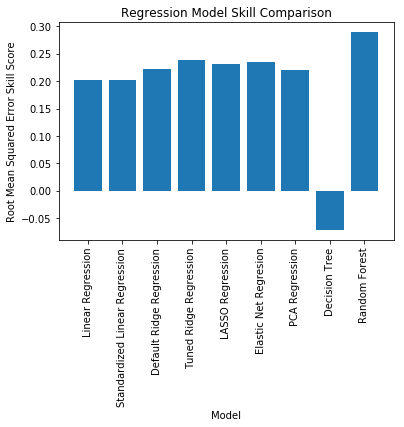

In [620]:
all_rsmess = [rmse_ss_test, rmse_ss_test_std, rmse_ss_test_ridge, rmse_ss_test_bridge, rmse_ss_test_blasso, rmse_ss_test_ben, rmse_ss_test_bpca, rmse_ss_test_dt_def, rmse_ss_test_rf_reg]
reg_legend = ['Linear Regression', 'Standardized Linear Regression', 'Default Ridge Regression', 'Tuned Ridge Regression', 'LASSO Regression', 'Elastic Net Regresion', 'PCA Regression', 'Decision Tree', 'Random Forest']
plt.figure(4)
plt.xticks(rotation='vertical')
plt.bar(range(len(reg_legend)), all_rsmess, tick_label=reg_legend)
plt.ylabel('Root Mean Squared Error Skill Score')
plt.xlabel('Model')
plt.title('Regression Model Skill Comparison')
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig4.png', bbox_inches='tight')
else:
    plt.show()

And then Classification:

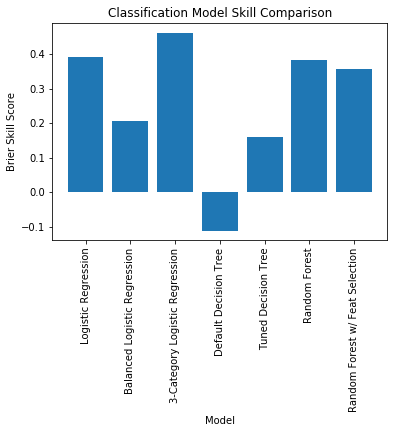

In [621]:
plt.figure(5)
plt.xticks(rotation='vertical')
all_bss = [bss_logreg, bss_logreg_bal, rpss, bss_dt_def, bss_dt_opt, bss_rf_opt, bss_rf_select]    
class_legend = ['Logistic Regression', 'Balanced Logistic Regression', '3-Category Logistic Regression', 'Default Decision Tree', 'Tuned Decision Tree', 'Random Forest', 'Random Forest w/ Feat Selection']
plt.bar(range(len(class_legend)), all_bss, tick_label=class_legend)
plt.ylabel('Brier Skill Score')
plt.xlabel('Model')
plt.title('Classification Model Skill Comparison')
if SAVE_FIGS:
    plt.savefig(plot_dir + '/' + 'short_course_fig5.png', bbox_inches='tight')
else:
    plt.show()

Finally, let's save our RandomForestClassifier so that we can use it again:

In [ ]:
joblib.dump(rf, out_dir + '/' + 'tutorial_rf_classifier.pkl')

['./models/tutorial_rf_classifier.pkl']

There are many other machine learning algorithms for both regression and classification tasks. See my course notes for a brief description of some of them, and stay tuned for more detailed discussion of one class of algorithms after lunch: (deep) neural nets!

These cutting edge algorithms present some benefits (as well as a few drawbacks) compared with those we have already discussed, and have a promising future in development.

But most importantly, sklearn makes it easy to try out different approaches. So when computational/time resources allow, try out different methods and discover which one(s) work best for your research task. Sometimes the result will surprise you!